In [13]:
# Import libraries

import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [14]:
# Read CSV files

PROJECT_ROOT = Path.cwd().parent.parent
DATASET_DIR = PROJECT_ROOT / "datasets"
PRIO_DIR = DATASET_DIR / "prio-cpu.csv"
RR_DIR = DATASET_DIR / "rr-cpu.csv"

df_prio = pd.read_csv(PRIO_DIR)
df_rr = pd.read_csv(RR_DIR)

# Add scheduler label
df_prio["scheduler"] = "PRIORITY"
df_rr["scheduler"] = "RR"

# Add ID for both
df_prio["id"] = df_prio.index + 1
df_rr["id"] = df_rr.index + 1

df = pd.concat([df_prio, df_rr], ignore_index=True)

In [15]:
metrics = [c for c in df.columns if c not in ["time_ms", "scheduler", "id"]]

X = df[metrics].copy()

X.head(5)

,cpu_psi_some_10,cpu_psi_some_60,cpu_psi_some_300,cpu_psi_full_10,cpu_psi_full_60,cpu_psi_full_300,io_psi_some_10,io_psi_some_60,io_psi_some_300,io_psi_full_10,...,mem_psi_some_300,mem_psi_full_10,mem_psi_full_60,mem_psi_full_300,load_avg_1,load_avg_5,load_avg_15,procs_running,procs_blocked,procs_disk_io
0,3.14,2.19,0.72,0,0,0,0.01,0.15,0.13,0.01,...,0,0,0,0,2.09,1.25,0.50,4,0,0
1,4.20,2.41,0.78,0,0,0,0.01,0.14,0.13,0.01,...,0,0,0,0,2.09,1.25,0.50,3,0,0
2,4.20,2.41,0.78,0,0,0,0.01,0.14,0.13,0.01,...,0,0,0,0,2.25,1.29,0.52,3,0,0
3,4.52,2.53,0.82,0,0,0,0.01,0.14,0.13,0.01,...,0,0,0,0,2.25,1.29,0.52,2,0,0
4,4.52,2.53,0.82,0,0,0,0.01,0.14,0.13,0.01,...,0,0,0,0,2.25,1.29,0.52,2,0,0


In [16]:
X = X.fillna(X.median())

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

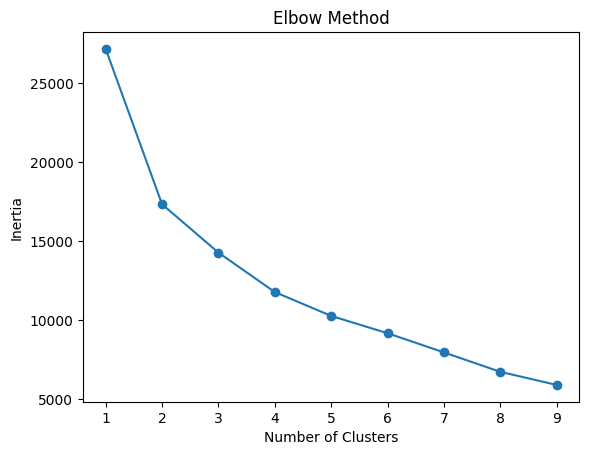

In [18]:
inertia = []

K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

import matplotlib.pyplot as plt

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

In [20]:
print(pd.crosstab(df["cluster"], df["scheduler"], normalize="index"))

scheduler  PRIORITY        RR
cluster                      
0          0.392791  0.607209
1          1.000000  0.000000


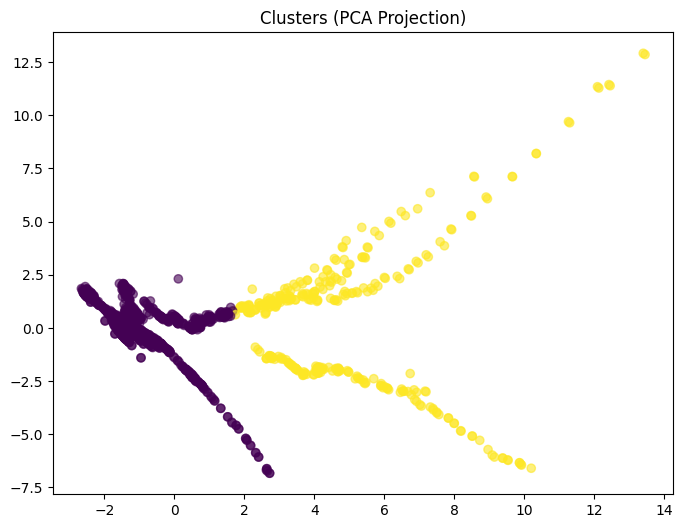

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], alpha=0.6)
plt.title("Clusters (PCA Projection)")
plt.show()


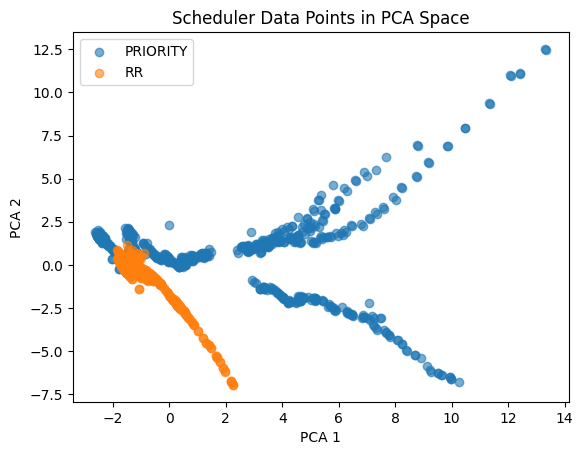

In [22]:
metrics = [c for c in df.columns if c not in ["time_ms", "scheduler", "id"]]

X = df[metrics].copy()
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:,0]
df["pca2"] = X_pca[:,1]

for sched in df["scheduler"].unique():
    sub = df[df["scheduler"] == sched]
    plt.scatter(sub["pca1"], sub["pca2"], label=sched, alpha=0.6)

plt.legend()
plt.title("Scheduler Data Points in PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()